In [3]:
# advance neuro project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [37]:
def ReLU(x):
    zeros_mat = np.zeros(x.shape)
    output = np.fmax(x,zeros_mat)
    return output

In [39]:
def ReLU_deriv(x):
    non_negs = np.where(x >= 0)
    output = np.zeros(x.shape)
    output[non_negs] = 1
    return output

In [6]:
def angleCal(A, B):
    num = np.trace(np.matmul(np.conjugate(A.T), B))
    norm_A = math.sqrt(np.trace(np.matmul(A,np.conjugate(A.T))))
    norm_B = math.sqrt(np.trace(np.matmul(B,np.conjugate(B.T))))
    denum = norm_A*norm_B
    angle = np.arccos(num/denum)*180/math.pi
    return angle

In [ ]:
def n_hot_coder(x,n):
    
    return

In [134]:
#### network parameters - open loop 2 layer network - first condition - auto correlated 

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

forward_weight_0 = np.random.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size))
forward_weight_1 = np.random.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size))

# here, the network is open loop and the delta2 is created randomly and kept constant during itertions
backward_weight_1 = np.random.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size))

# input layer values
input_layer = np.random.normal(mu, sigma, size=(n_b, input_layer_size)) # initial value of inputs - constant during iterations
error_delta2 = np.random.normal(mu, sigma, size=(n_b, output_layer_size)) # initial value of error_delta 2 - constant during iterations
error_delta1 = np.matmul(error_delta2, backward_weight_1) # initial value of error_delta1 - constant during iterations since
# delta 2 doesn't change

# updating the network parameters
rep = 10
angles1 = np.zeros((rep, number_of_iterations))

for k in range (rep):
    forward_weight_0 = np.random.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size))
    forward_weight_1 = np.random.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size))
    for j in range (number_of_iterations):
        angles1[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = np.matmul(forward_weight_0.T, input_layer.T).T
        hidden_layer_1 = ReLU(Z1)
        delta1 = np.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*np.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*np.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


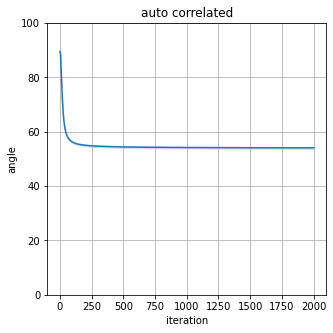

In [135]:
## plot the result of auto correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5));
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles1,0));
ax.set_ylim([0, 100]);
ax.set_title('auto correlated');
ax.set_ylabel('angle');
ax.set_xlabel('iteration');
ax.grid(True);

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles1,0)-np.std(angles1,axis=0), np.mean(angles1,0)+np.std(angles1,axis=0),\
                color='b', alpha=.1);


In [136]:
#### network parameters - open loop 2 layer network - second condition - cross correlated 

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

forward_weight_0 = np.random.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size))
forward_weight_1 = np.random.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size))

# here, the network is open loop and the delta2 is created randomly and kept constant during itertions
backward_weight_1 = np.random.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size))

# input layer values
input_layer = np.random.normal(mu, sigma, size=(n_b, input_layer_size)) 
error_delta2 = input_layer # cross correlated with inputs of network
error_delta1 = np.matmul(error_delta2, backward_weight_1) 

# updating the network parameters
rep = 10
angles2 = np.zeros((rep, number_of_iterations))

for k in range (rep):
    forward_weight_0 = np.random.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size))
    forward_weight_1 = np.random.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size))
    for j in range (number_of_iterations):
        angles2[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = np.matmul(forward_weight_0.T, input_layer.T).T
        hidden_layer_1 = ReLU(Z1)
        delta1 = np.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*np.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*np.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        # generate the parameters again
        input_layer = np.random.normal(mu, sigma, size=(n_b, input_layer_size)) 
        error_delta2 = input_layer
        error_delta1 = np.matmul(error_delta2, backward_weight_1) 
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


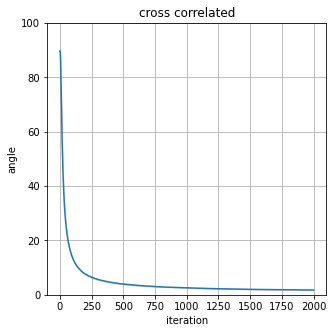

In [137]:
# plot the result of cross correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles2,0))
ax.set_ylim([0, 100])
ax.set_title('cross correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles2,0)-np.std(angles2,axis=0), np.mean(angles2,0)+np.std(angles2,axis=0),\
                color='b', alpha=.1);


In [139]:
#### network parameters - open loop 2 layer network - third condition - not auto correlated nor cross correlated

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

forward_weight_0 = np.random.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size))
forward_weight_1 = np.random.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size))

# here, the network is open loop and the delta2 is created randomly and kept constant during itertions
backward_weight_1 = np.random.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size))

# input layer values
input_layer = np.random.normal(mu, sigma, size=(n_b, input_layer_size)) 
error_delta2 = np.random.normal(mu, sigma, size=(n_b, input_layer_size)) 
error_delta1 = np.matmul(error_delta2, backward_weight_1)

# updating the network parameters
rep = 10
angles3 = np.zeros((rep, number_of_iterations))

for k in range (rep):
    forward_weight_0 = np.random.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size))
    forward_weight_1 = np.random.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size))
    for j in range (number_of_iterations):
        angles3[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = np.matmul(forward_weight_0.T, input_layer.T).T
        hidden_layer_1 = ReLU(Z1)
        delta1 = np.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*np.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*np.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        # generate the parameters again
        input_layer = np.random.normal(mu, sigma, size=(n_b, input_layer_size)) 
        error_delta2 = np.random.normal(mu, sigma, size=(n_b, output_layer_size)) 
        error_delta1 = np.matmul(error_delta2, backward_weight_1) 
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


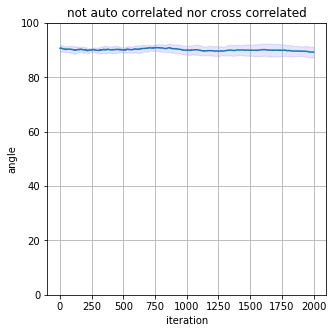

In [140]:
# plot the result of not auto correlated nor cross correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles3,0))
ax.set_ylim([0, 100])
ax.set_title('not auto correlated nor cross correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles3,0)-np.std(angles3,axis=0), np.mean(angles3,0)+np.std(angles3,axis=0),\
                color='b', alpha=.1);


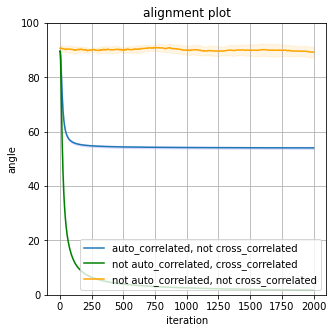

In [141]:
# plot the result of all three conditions together

    
fig, ax = plt.subplots(1,1,figsize=(5,5))

# condition 1
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles1,0))
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence1 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles1,0)-np.std(angles1,axis=0), np.mean(angles1,0)+np.std(angles1,axis=0),\
                color='b', alpha=.1);

# condition 2
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles2,0),color='green')
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence2 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles2,0)-np.std(angles2,axis=0), np.mean(angles2,0)+np.std(angles2,axis=0),\
                color='green', alpha=.1);

# condition 3
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles3,0),color='orange')
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence3 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles3,0)-np.std(angles3,axis=0), np.mean(angles3,0)+np.std(angles3,axis=0),\
                color='orange', alpha=.1);

ax.legend(['auto_correlated, not cross_correlated','not auto_correlated, cross_correlated',\
           'not auto_correlated, not cross_correlated'],loc='lower right')

In [ ]:
# Paper Part - 2.3 Using the provided theoretical tool to investigate FA in the learning process of a practical deep ANN
# train and test a 5 layer network on MNIST
# fact = tanh(ReLU) - 50 neurons in all hidden and output layer - output layer is using 5 hot coding
# images of MNIST should be resized to 15*15 - so we have 225 neurons in input layer 
# inputs should be normalized 
# batch size = 1000, 60 batches available (total numbre of 60K images)
# initialization of forward/ backward weights and biases is done using N(0,0.1)
# loss function is sth like squared error, check page 5 for the details

In [177]:
# Load MNIST Dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

# loading the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('data loaded!')
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

data loaded!
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [176]:
# resize images to 15*15

x_train_resized = np.zeros((x_train.shape[0],15,15))
x_test_resized = np.zeros((x_test.shape[0],15,15))

# resize train images
for i in range (x_train.shape[0]):
    image = np.squeeze(x_train[i,:,:])
    x_train_resized[i,:,:] = np.resize(image,(15,15))

    
# resize test images
for i in range (x_test.shape[0]):
    image = np.squeeze(x_test[i,:,:])
    x_test_resized[i,:,:] = np.resize(image,(15,15))
    
print('resizing done!')
print(x_train_resized.shape,x_test_resized.shape)

resizing done!
(60000, 15, 15) (10000, 15, 15)


In [175]:
# vectorize images

x_train_flat = x_train_resized.reshape(x_train_resized.shape[0],-1)
x_test_flat = x_test_resized.reshape(x_test_resized.shape[0],-1)
print('vectorization done!')
print(x_train_flat.shape,x_test_flat.shape)

vectorization done!
(60000, 225) (10000, 225)


In [174]:
# normalize images with train images
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train_flat)
x_tr_norm = scaler.transform(x_train_flat)
x_te_norm  = scaler.transform(x_train_flat)

print('normalization done!')

normalization done!


In [ ]:
# 5 hot coding the labels